# Intro

This notebook demonstrates the use of the tweeteater functions. The goal of the tweeteater library is to provide functions that allow simple loading of large Twitter datasets collected from the streaming API. It particularly allows to extract nested observations of engagements.

# Parameters

In [39]:
# the directory with the tweets 
directory = '/Volumes/Data/mt_data/fr/json_cleaned'
# the extension of the tweet files in the directory
extension = '.jsonl'

# Load, subset tweets and analyse types

At first, we now want to load all tweets in the directory and filter them. We can filter on two conditions, 1. being that we only keep certain types of tweet, 2. we can provide a custom subsetting function. Regarding 1.: a tweet can be a a) retweet of a tweet, b) a replie to a tweet c) a quote of a tweet or d) just an original tweet, that is a tweet that is neither a) - c). A) - c) are not necessarily mutually exclusive.  

In [40]:
import pandas as pd
from lib.eat_tweets import *
from lib.utils import *

We now only want to keep tweets made by certain users, which are in this case political accounts, and hence define a custom subset function that acts directly on the tweet object 

In [41]:
pt = '/Users/richardknudsen/Downloads/france_target_screennames.csv'
politicians_screennames = set(pd.read_csv(pt, header=None)[0].tolist())
subset_func = lambda tweet: safe_get(tweet, *('user', 'screen_name')) in politicians_screennames

In [47]:
politicians_screennames

{'3807Limon',
 'AChristine_Lang',
 'AFBrunet_4403',
 'AGenetet',
 'ALCattelot',
 'AQuatennens',
 'AVFreschi',
 'AVilliers2017',
 'A_Ardisson',
 'AbadieCaroline',
 'AlainDavid_AN',
 'AlainTourret',
 'Alain_Bruneel',
 'AlbaneGaillot',
 'AliceThourot',
 'AndreChassaigne',
 'Anissa_Khedher',
 'AnnaigLeMeur_AN',
 'AnneBlanc_12',
 'AnneBrugnera',
 'AnnieGenevard',
 'AudeAmadou',
 'AudeBono',
 'AudeLuquet2017',
 'AurelienPradie',
 'Aurelientache',
 'BBrocard',
 'BCouillard33',
 'BDeflesselles',
 'BHammouche5708',
 'BJoncour',
 'BQuestel',
 'B_BessotBallot',
 'B_Peyrol',
 'Bannier_G',
 'BeaudouinSo',
 'BechtGroff2017',
 'BenedictTaurine',
 'BenjaminDirx',
 'BenoitSimian',
 'BertrandBouyx',
 'BertrandPancher',
 'BertrandSorre',
 'BonnivardE',
 'BorisVallaud',
 'BrigBourguignon',
 'Brigitte_Kuster',
 'BrunoBilde',
 'BrunoBonnellOff',
 'BrunoDuverge',
 'BrunoMillienne',
 'BuonTAN',
 'CGrandjean54',
 'CKamowski3805',
 'CMUSCHOTTI',
 'CORDIERPierre08',
 'C_deCourson',
 'CaroleBBonnard',
 'CarolineF

Furthermore, we decide that we want to keep all tweettypes.

In [42]:
keep_tweettypes = ['original', 'retweet', 'reply', 'quote']

Now we are ready to load the tweets.

In [43]:
filepaths = get_filepaths(directory, extension)
n_filepaths = len(list(get_filepaths(directory, extension)))
tweettypes = eat_tweettypes(filepaths, subset_func=subset_func, n_filepaths=n_filepaths)

  0%|          | 0/590 [00:00<?, ?it/s]

The tweettypes object is a generator using lazy loading. Since the sample dataset used here is small, we can safely convert it into a dictionary, but with larger datasets, this should be avoided. 

In [44]:
tweettypes = dict(tweettypes); print('n tweets:', len(tweettypes))

100%|██████████| 590/590 [07:01<00:00,  2.01s/it]

n tweets: 16680


We now want to see the distribution across tweettypes

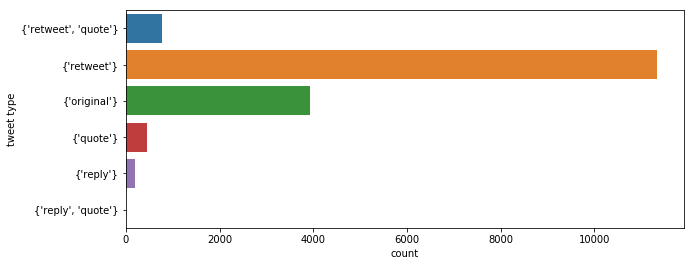

In [45]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

tweettypes_df = pd.DataFrame({'tweet type': [str(x) for x in tweettypes.values()]})
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(data=tweettypes_df, y='tweet type', ax=ax)

Since we are only interested in original tweets, we subset accordingly

In [46]:
ids = [id_ for id_, types in tweettypes.items() if 'original' in types]
print('n original tweets', len(ids))

n original tweets 3931


# Extract more attributes

We want to know a little more about the tweets, so we want to extract some more attributes. A comprehensive overview of all atributes of the tweet object can be found here: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html

In [33]:
attributes = ['created_at', 'user.screen_name', 'user.name', 'text', 'lang']
filepaths = get_filepaths(directory, extension)
n_filepaths = len(list(get_filepaths(directory, extension)))
tweet_attributes = eat_tweetattributes(filepaths, ids, attributes, n_filepaths=n_filepaths)
tweet_attributes = pd.DataFrame([[a] + b for a, b in tweet_attributes])
tweet_attributes.columns = ['id'] + attributes

100%|██████████| 9/9 [00:00<00:00,  9.07it/s]


In [34]:
tweet_attributes.head()

,id,created_at,user.screen_name,user.name,text,lang
0,848771927716106240,Mon Apr 03 05:39:31 +0000 2017,valerieboyer13,Valérie Boyer ن,Quand les analyses du poids numérique reflèten...,fr
1,848773698467311617,Mon Apr 03 05:46:33 +0000 2017,valerieboyer13,Valérie Boyer ن,Quand @Filteris bouscule les analyses des sond...,fr
2,848811235340685312,Mon Apr 03 08:15:43 +0000 2017,desarnez,Marielle de Sarnez,"La véritable alternance pour le pays, porteuse...",fr
3,848814218581336064,Mon Apr 03 08:27:34 +0000 2017,lesRepublicains,les Républicains,Vous ne pourrez pas vous rendre au bureau de v...,fr
4,848815699015413760,Mon Apr 03 08:33:27 +0000 2017,luccarvounas,Luc Carvounas,"A alfortville, d'anciens sdf retrouvent un toi...",fr


# Extracting engagements

We now also want to know, how many engagements (favourites, replies, retweets, quotes) the original tweets from the politicians received. We can extract this in the following way

In [35]:
filepaths = get_filepaths(directory, extension)
n_filepaths = len(list(get_filepaths(directory, extension)))
engagements = eat_engagements(filepaths, ids, n_filepaths=n_filepaths)
engagements = pd.DataFrame(list(engagements))
engagements.columns = ['observed timestamp', 'observed in tweet.id', 'tweet.id', 
                       'engagement type', 'count']

100%|██████████| 9/9 [00:00<00:00,  7.70it/s]


In [36]:
engagements.head()

,observed timestamp,observed in tweet.id,tweet.id,engagement type,count
0,Mon Apr 03 05:40:00 +0000 2017,848772048675622915,848771927716106240,favourite_count,0
1,Mon Apr 03 05:40:00 +0000 2017,848772048675622915,848771927716106240,retweet_count,1
2,Mon Apr 03 05:40:03 +0000 2017,848772060470013952,848771927716106240,favourite_count,0
3,Mon Apr 03 05:40:03 +0000 2017,848772060470013952,848771927716106240,retweet_count,2
4,Mon Apr 03 05:40:09 +0000 2017,848772085082193920,848771927716106240,favourite_count,0


Note that the engagement types 'favourite_count' and 'retweet_count' correspond to the actual counts according to Twitter at the time 'tweet extracted from' was made. Hence, these are cumulative counts. 'reply' and 'quote' simply mark a reply or a quote within our dataset, hence the count is always 1. Let's now see, which tweets have the highest engagements

Let's now add some more columns to this. 

In [37]:
tweetid2screenname = dict(zip(tweet_attributes['id'], tweet_attributes['user.screen_name']))
tweetid2createdat = dict(zip(tweet_attributes['id'], tweet_attributes['created_at']))
engagements['user.screen_name'] = [tweetid2screenname[id_]
                                   for id_ in engagements['tweet.id']]
engagements['created_at'] = [tweetid2createdat[id_]
                             for id_ in engagements['tweet.id']]

In [38]:
engagements.head()

,observed timestamp,observed in tweet.id,tweet.id,engagement type,count,user.screen_name,created_at
0,Mon Apr 03 05:40:00 +0000 2017,848772048675622915,848771927716106240,favourite_count,0,valerieboyer13,Mon Apr 03 05:39:31 +0000 2017
1,Mon Apr 03 05:40:00 +0000 2017,848772048675622915,848771927716106240,retweet_count,1,valerieboyer13,Mon Apr 03 05:39:31 +0000 2017
2,Mon Apr 03 05:40:03 +0000 2017,848772060470013952,848771927716106240,favourite_count,0,valerieboyer13,Mon Apr 03 05:39:31 +0000 2017
3,Mon Apr 03 05:40:03 +0000 2017,848772060470013952,848771927716106240,retweet_count,2,valerieboyer13,Mon Apr 03 05:39:31 +0000 2017
4,Mon Apr 03 05:40:09 +0000 2017,848772085082193920,848771927716106240,favourite_count,0,valerieboyer13,Mon Apr 03 05:39:31 +0000 2017
